# Project Introduction

Digital Education in India is increasing day by day with the advancement of web-based learning services, specifically, eLearning platforms. The rise of new digital technology also brings new challenges. Digital classrooms are conducted via the videotelephony software program (ex-Zoom) where it’s not possible to see all students and access the mood. Students are not focusing on content due to a lack of surveillance, but this challenge can be overcome by applying deep learning algorithms to live video data.

The solution to this problem is by recognizing the face, mark the attendance, log the individual’s session time and put a drowsiness alert.


## Face Recognition

In [1]:
# import libraries
import cv2
import time, math
import h5py
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Convolution2D, MaxPool2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from math import sin, cos, pi
from tqdm import tqdm

In [2]:
# constants
INPUT_SHAPE = (128,128)  # model input shape
N_FEATURES = 68  # number of facial features

In [3]:
# check the resources
print(os.listdir('../../datasets/'))  # path to image data for training 
print(os.listdir('../input'))   # saved models

['300W', 'Helen']
['best_model_3.hdf5', 'haarcascade_frontalface_default.xml']


Face recognition algorithms can extract features from a face image namely positions of forehead, eyes, nose, mouth, chin, jaws. 

Face Landmarks – There are 68 specific points (called landmarks) that exist on every face. 



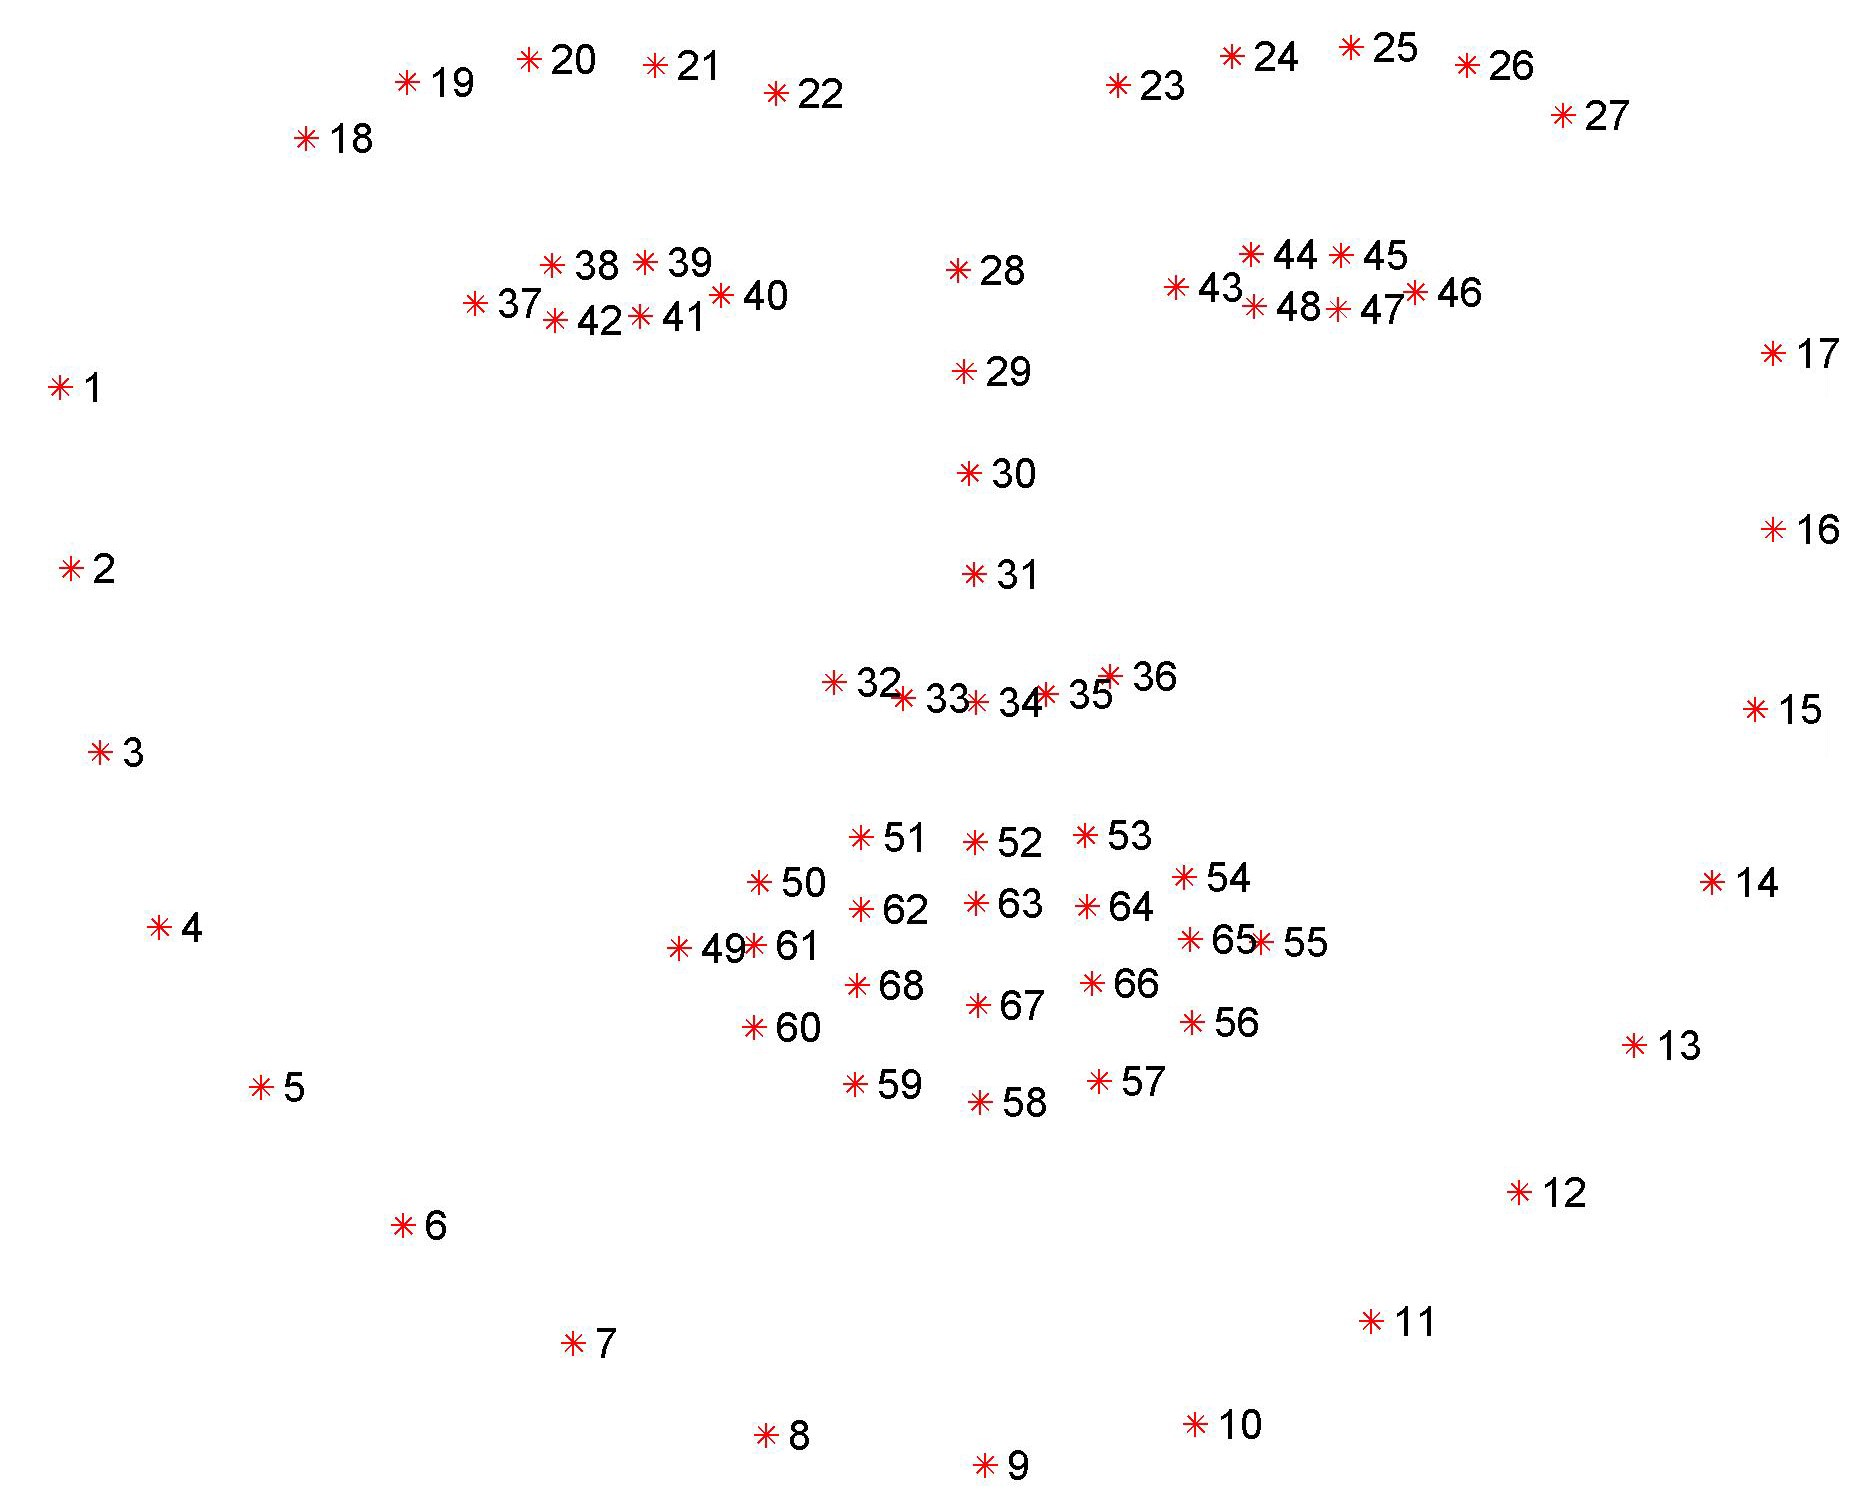

To identify these facial landmarks, we need to detect a face from the image.

I am using OpenCV with the 'Haar cascade frontal face' classifier to detect the face from the image. It will return a list of rectangle points that form a bounding box on the detected face.


In [4]:
# create a face detector object
frontal_cascade_path = '../input/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(frontal_cascade_path)

In [5]:
# function to recursively load all the paths for each images inside current directory
def load_paths(dir_path):
    paths = []
    dir_path_list = os.listdir(dir_path)
    for path in dir_path_list:
        if os.path.isdir(dir_path + '/' + path):
            # use DFS to get each file from nested directories
            paths.extend(load_paths(dir_path + '/' + path))
        else:
            # add full file path from root directory
            paths.append(dir_path + '/' + path)
    return np.array(paths, dtype=object)

In [6]:
# create training data path to load images
train_data_path = load_paths('../../datasets')
train_data_path

array(['../../datasets/300W/01_Indoor/indoor_001.png',
       '../../datasets/300W/01_Indoor/indoor_001.pts',
       '../../datasets/300W/01_Indoor/indoor_002.png', ...,
       '../../datasets/Helen/trainset/296814969_1.pts',
       '../../datasets/Helen/trainset/296814969_2.jpg',
       '../../datasets/Helen/trainset/296814969_2.pts'], dtype=object)

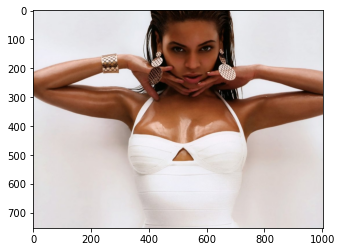

In [7]:
# check first image
test_image_01 = cv2.imread(train_data_path[0])
plt.imshow(cv2.cvtColor(test_image_01, cv2.COLOR_BGR2RGB))

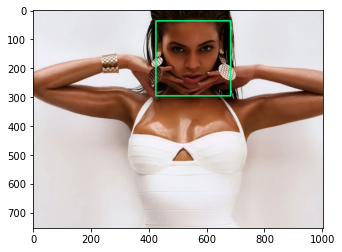

In [8]:
# detect face using 'Haar cascade'
faces = faceCascade.detectMultiScale(test_image_01)
# create bounding box
for x, y, w, h in faces:
    cv2.rectangle(test_image_01,(x,y),(x+w, y+h),(127, 255,0),3)
# show the test image
plt.imshow(cv2.cvtColor(test_image_01, cv2.COLOR_BGR2RGB))

Detecting faces from OpenCV is fast and accurate.

Now, let's check how landmarks are labeled on the image.


In [9]:
# function to read points from the file
def read_pts(filename):
    landmarks = np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))
    # return a 1D array containing all the points with X location at even number and Y location at odd number of index
    return np.array(landmarks) 

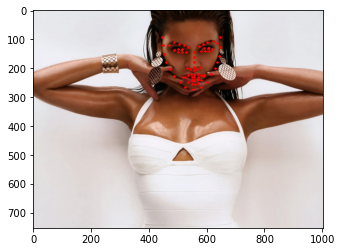

In [10]:
test_image_01 = cv2.imread(train_data_path[0])
test_points_01 = read_pts(train_data_path[1])
plt.imshow(cv2.cvtColor(test_image_01, cv2.COLOR_BGR2RGB))
plt.scatter(test_points_01[:,0], test_points_01[:,1], marker='.', s=10, color='red')

We have facial landmarks and a face detector now we can extract the face region from the image to use it as input for our face recognition model.


In [11]:
# function to check if a rectangle covers more than half points
def can_cover(rect, pts_arr):
    x,y,w,h = rect
    num_pts = ((pts_arr[:,0]>x) & (pts_arr[:,0]<(x+w)) & (pts_arr[:,1]>y) & (pts_arr[:,1]<(y+h))).sum()
    # if bounding box from detector contains 2/3rd points out of N_FEATURES we consider it as possitive case
    min_features = int(N_FEATURES*2/3)
    if num_pts > min_features:
        return True
    else:
        return False

In [12]:
# function to get croped image of face region from the given image and face landmarks
def extract_face(img_path, pts_path):
    # read the image
    img = cv2.imread(img_path)
    # detect faces 
    faces = faceCascade.detectMultiScale(img)
    # read landmark points
    landmark_pts = read_pts(pts_path)
    # out of all detected faces isolate the face with landmark points  
    for face in faces:
        if can_cover(face, landmark_pts):
            # return croped image with points array
            x, y, w, h = face[0], face[1], face[2], face[3]
            # it is possible that few of landmarks are out of the bounding box 
            # so take the maximum number of pixel that can cover all the landmarks
            x_min = int(min(min(landmark_pts[:,0]), x))
            x_max = int(max(max(landmark_pts[:,0]), x + w))
            y_min = int(min(min(landmark_pts[:,1]), y))
            y_max = int(max(max(landmark_pts[:,1]), y + h))
            # adjust landmarks locations
            landmark_pts[:,0] = landmark_pts[:,0] - x_min
            landmark_pts[:,1] = landmark_pts[:,1] - y_min        
            return img[y_min:y_max, x_min:x_max], landmark_pts
        
    # face detector have not detected a face from the image
    return (None,None)

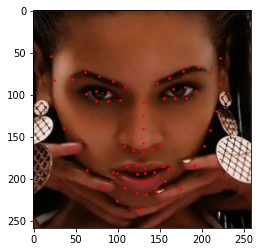

In [13]:
# test for the functions to extract face region from the image
face, landmarks = extract_face(train_data_path[0],train_data_path[1])
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.scatter(landmarks[:,0], landmarks[:,1], marker='.', s=10, color='red')

In [3]:
# array of required point numbers
REQ_PTS = [17,21,22,26,27,31,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,51,54,57]
REQ_PTS_SIZE = len(REQ_PTS)

Using less landmark makes processing faster so, I am using only 20 landmarks to recognize the face.

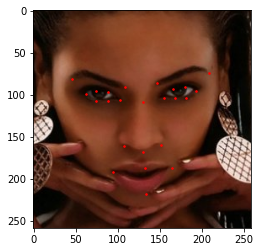

In [15]:
landmarks_new = landmarks[REQ_PTS]
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.scatter(landmarks_new[:,0], landmarks_new[:,1], marker='.', s=10, color='red')

In [16]:
# function to load training data
def load_data(dir_path):
    images = []
    points = []
    # get all the path for files
    file_paths = load_paths(dir_path)
    # name of image file and its points file are same and also they are in same directory so we can 
    # identify image file and its landmark points file with file extensions
    file_paths = np.sort(file_paths)
    # image file have extensions like: '.jpg', '.jpeg', '.png'
    # points file have extension '.pts'
    max_count = len(file_paths)
    for i in tqdm(range(max_count)): # tqdm -> display progress
        img = None 
        pts = None
        if file_paths[i][-4:] in ['.jpg', 'jpeg', '.png']:
            # found a image file
            img = file_paths[i]
            # check if matching pts file exist
            if file_paths[i+1][-4:] in ['.pts']:
                i = i + 1  # modify iterator to point to next file
                pts = file_paths[i]
                # try to extract face region from the image
                face, landmarks = extract_face(img, pts)
                if face is None:
                    # can not find face in the image
                    pass
                else:
                    images.append(face)
                    # save only required points
                    points.append(landmarks[REQ_PTS])
    print('Loaded ', len(images), ' images')
    return images, points

In [17]:
X, Y = load_data('../../datasets')

100%|██████████████████████████████████████████████████████████████████████████████| 5860/5860 [16:17<00:00,  6.00it/s]


Loaded  2580  images


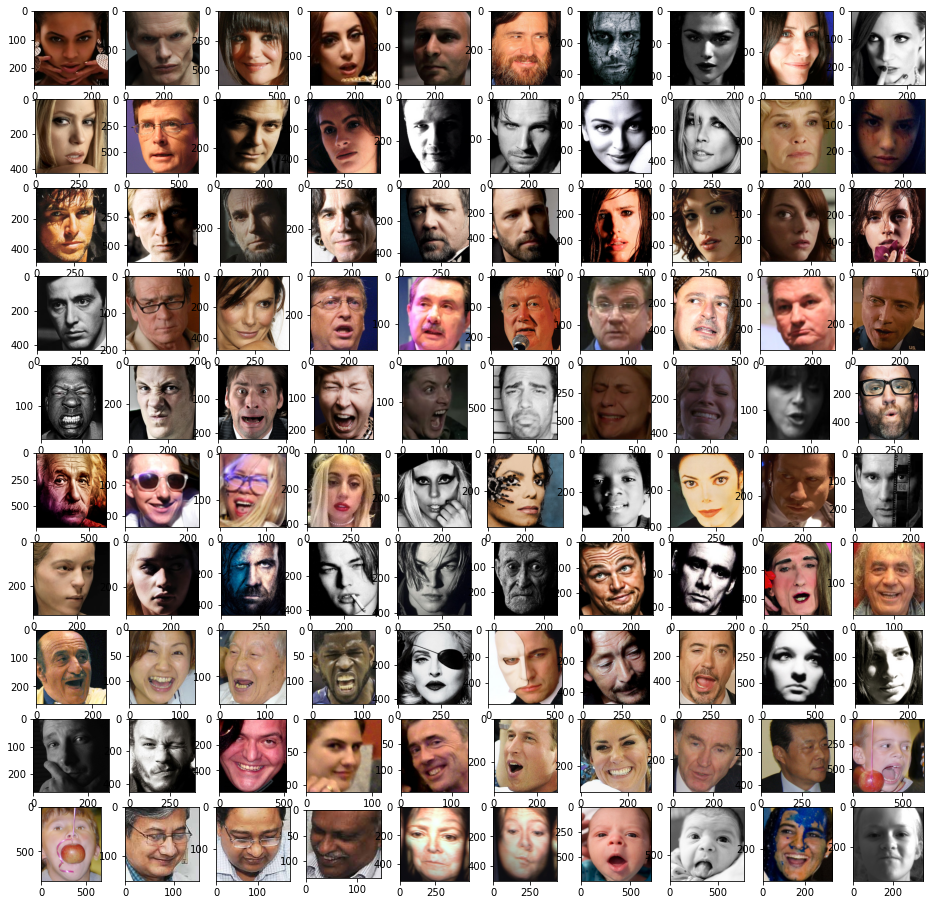

In [18]:
# check loaded images
fig = plt.figure(figsize=(16, 16))
for i in range(100):
    fig.add_subplot(10, 10, i+1)
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))   

### Dataset creation

In [19]:
# function to resize images based on model input shape
def resize_images(images, points, in_shape):
    resized_image = []
    resized_points = []
    for i in tqdm(range(len(images))):
        img = images[i]
        pts = points[i]
        x_scale = in_shape[1]/img.shape[1]
        y_scale = in_shape[0]/img.shape[0]
        # scale landmarks locations 
        pts[:,0] = pts[:,0] * x_scale
        pts[:,1] = pts[:,1] * y_scale      
        # resize the image to fit in model
        res_img = cv2.resize(img, dsize=(in_shape), interpolation=cv2.INTER_CUBIC)
        resized_image.append(res_img)
        resized_points.append(pts)
    # convert list to np array 
    return np.array(resized_image), np.array(resized_points)

In [20]:
# rescale images
X_train, Y_train = resize_images(X, Y, INPUT_SHAPE)

100%|█████████████████████████████████████████████████████████████████████████████| 2580/2580 [00:24<00:00, 104.43it/s]


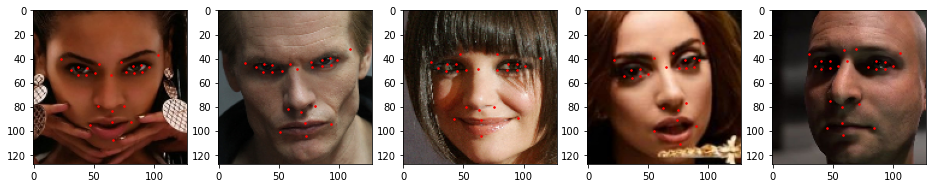

In [21]:
# check loaded images
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.scatter(Y_train[i][:,0], Y_train[i][:,1], marker='.', s=10, color='red')

In [22]:
# check shape of array
print(X_train.shape, Y_train.shape)

(2580, 128, 128, 3) (2580, 24, 2)


In [26]:
# save dataset to hard drive
data_file = h5py.File('../input/ResizedImageDataset.h5', 'w')
img_shape = None, X_train.shape[1], X_train.shape[2], X_train.shape[3]
pts_shape = None, Y_train.shape[1], Y_train.shape[2]
data_file.create_dataset('images', data=X_train, compression="gzip", chunks=True, maxshape=img_shape)
data_file.create_dataset('landmarks', data=Y_train, compression="gzip", chunks=True, maxshape=pts_shape) 
data_file.close()

## Data Augmentation

In [4]:
# class to fetch data from dataset
class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        # open file in read mode
        with h5py.File(self.file, 'r') as hf:
            # get one element at a time
            for i in tqdm(range(len(hf['images']))):
                yield hf['images'][i],hf['landmarks'][i]

In [228]:
# create a dataset object to read data
ds = tf.data.Dataset.from_generator(
    generator('../input/ResizedImageDataset.h5'), 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=([128,128,3], [24,2]))
ds.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(24, 2), dtype=tf.float32, name=None))

In [229]:
# function to show images from dataset
def show_images(dataset, num_img=5):
    i = 0
    fig = plt.figure(figsize=(16, 16)) 
    cols = 5 # default show 5 images in a row
    rows = math.ceil(num_img/cols)
    for img,pts in dataset.take(num_img):  # loop to generate images
        image = img.numpy()  # convert tensor to np array
        points = pts.numpy()
        fig.add_subplot(rows, cols, i+1)   
        i += 1
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.scatter(points[:,0], points[:,1], marker='.', s=10, color='red')

  0%|▏                                                                                | 4/2580 [00:00<05:21,  8.02it/s]


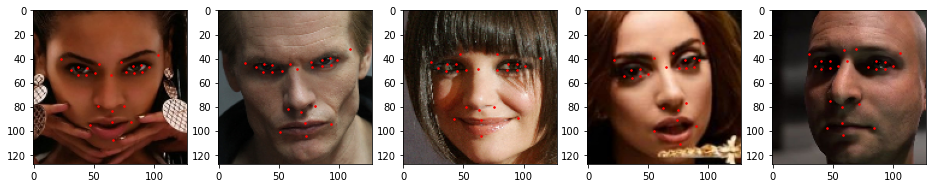

In [230]:
# show first 5 images from dataset
show_images(ds)

### Horizontal Flipping

In [231]:
# function to flip images horizontally
def horizontal_flip(image, points):
    # flip image
    flipped_image = tf.image.flip_left_right(image)
    # flip only x values, y value do not change in horizonal flip
    # create matrix to change only x values
    flip_matrix = tf.constant([-1,1], dtype=tf.float32)
    flipped_points = tf.multiply(flip_matrix, points)
    # adjust x point in image shape
    mask = tf.constant([INPUT_SHAPE[1],0], dtype=tf.float32)
    flipped_points = tf.add(mask, flipped_points)
    return flipped_image, flipped_points

In [232]:
# flip images horizontally
ds_hf = ds.map(horizontal_flip)

  0%|▏                                                                                | 7/2580 [00:00<04:03, 10.57it/s]


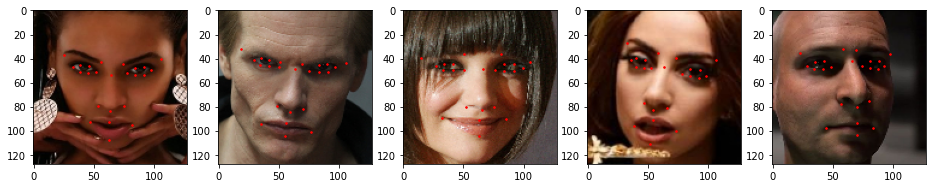

In [233]:
# show first 5 images from dataset
show_images(ds_hf)

In [234]:
# create augmentation pipeline  
ds_hf_aug = ds.concatenate(ds_hf)

## Brightness Alteration

In [235]:
# function to change brightness of images
def brightness_alter(image, points, factor=0.2):
    # Increased brightness by a factor & clip any values outside the range of [0,255]
    image = tf.math.scalar_mul((1+factor),tf.cast(image,tf.float32))  # cast to float type for multiplication 
    bright_image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=255) # clip the values
    return tf.cast(bright_image, tf.uint8), points  # recast to uint8

In [236]:
# increase brightness by 0.2
ds_bri = ds_hf_aug.map(lambda img,pts: brightness_alter(img,pts,factor=0.2))

  0%|▏                                                                                | 5/2580 [00:00<04:29,  9.54it/s]


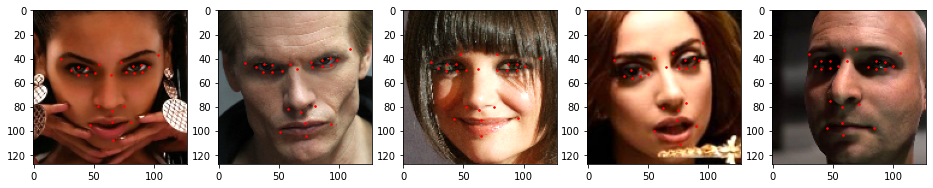

In [237]:
# show first 5 images from dataset
show_images(ds_bri)

In [238]:
# decrease brightness by 0.2
ds_brd = ds_hf_aug.map(lambda img,pts: brightness_alter(img,pts,factor=-0.2))

  0%|▏                                                                                | 5/2580 [00:00<04:20,  9.90it/s]


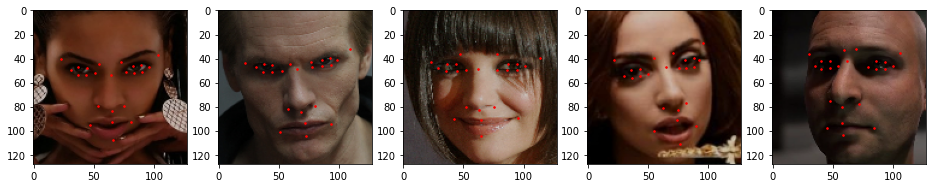

In [239]:
# show first 5 images from dataset
show_images(ds_brd)

In [240]:
# create augmentation pipeline  
ds_br = ds_bri.concatenate(ds_brd)
ds_br_aug = ds_hf_aug.concatenate(ds_br)

### Rotation Augmentation

In [241]:
# function to rotate images and points
def rotate_augmentation(image, points, angle):
    # obtain angle in radians from angle in degrees 
    radian = angle*pi/180
    # rotate image
    rotated_image = tfa.image.transform_ops.rotate(image, radian)
    # rotate points
    center = INPUT_SHAPE[0]/2, INPUT_SHAPE[1]/2
    # get center of rotation for all the points
    centered_points = tf.subtract(points, tf.constant(center,dtype=tf.float32))
    # x = x.cos(theta) - y.sin(theta)
    # y = x.sin(theta) + y.cos(theta)
    cos_theta = math.cos(-radian) # minus sign to adjust rotation direction
    sin_theta = math.sin(-radian)
    x_mask = tf.constant([1,0], dtype=tf.float32)
    y_mask = tf.constant([0,1], dtype=tf.float32)
    x_points = tf.multiply(x_mask, centered_points)
    y_points = tf.multiply(y_mask, centered_points)
    # x.cos(theta)
    x_cos_theta = tf.math.scalar_mul(cos_theta,x_points)
    # y.cos(theta)
    y_cos_theta = tf.math.scalar_mul(cos_theta,y_points)
    # x.sin(theta)
    x_sin_theta = tf.math.scalar_mul(sin_theta,x_points)
    # y.sin(theta)
    y_sin_theta = tf.math.scalar_mul(sin_theta,y_points)
    # switch x and y value with roll function on axis 1
    rotated_x_points = tf.subtract(x_cos_theta, tf.roll(y_sin_theta,shift=1,axis=1))
    rotated_y_points = tf.add(tf.roll(x_sin_theta,shift=1,axis=1), y_cos_theta)
    rotated_points = tf.add(rotated_x_points, rotated_y_points)
    return rotated_image, tf.add(rotated_points,tf.constant(center,dtype=tf.float32))

In [242]:
# rotate images by 20 degree counter clock wise
ds_rol = ds_br_aug.map(lambda img,pts: rotate_augmentation(img,pts,angle=20))

  0%|▏                                                                                | 5/2580 [00:00<04:41,  9.14it/s]


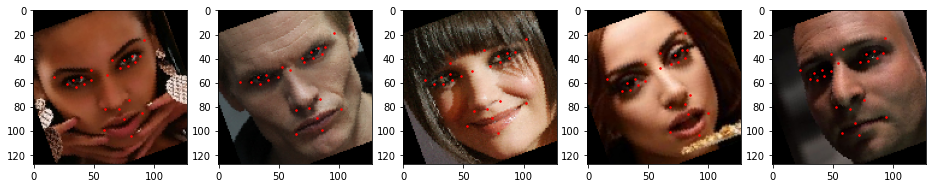

In [243]:
# show first 5 images from dataset
show_images(ds_rol)

In [244]:
# rotate images by 20 degree clock wise
ds_ror = ds_br_aug.map(lambda img,pts: rotate_augmentation(img,pts,angle=-20))

  0%|▏                                                                                | 5/2580 [00:00<04:12, 10.18it/s]


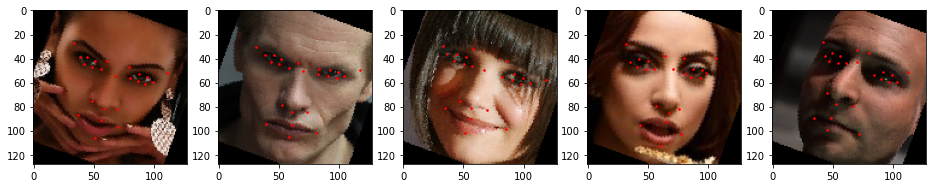

In [245]:
# show first 5 images from dataset
show_images(ds_ror)

In [246]:
# create augmentation pipeline  
ds_ro = ds_rol.concatenate(ds_ror)
ds_ro_aug = ds_br_aug.concatenate(ds_ro)

### Horizontal & Vertical shift

In [247]:
# function to shift image horizontaly and verticaly
def shift_image(image, points, shift=(0,0)):
    # shift images
    shifted_image = tfa.image.translate(image, tf.constant(shift,dtype=tf.float32))
    # shift points
    shifted_points = tf.add(points, tf.constant(shift,dtype=tf.float32))
    return shifted_image, shifted_points

In [248]:
# shift images left by 20 pixels
ds_sl = ds_br_aug.map(lambda img,pts: shift_image(img,pts,shift=(-20,0)))

  0%|▏                                                                                | 5/2580 [00:00<04:14, 10.11it/s]


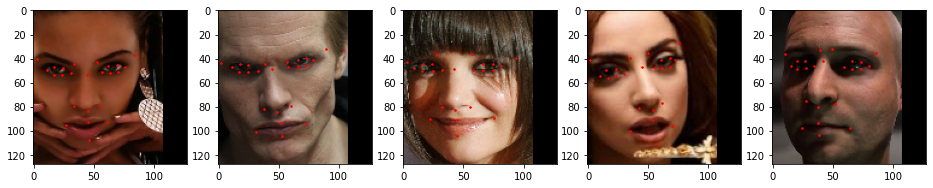

In [249]:
# show first 5 images from dataset
show_images(ds_sl)

In [250]:
# shift images right by 20 pixels
ds_sr = ds_br_aug.map(lambda img,pts: shift_image(img,pts,shift=(20,0)))

  0%|▏                                                                                | 5/2580 [00:00<04:13, 10.15it/s]


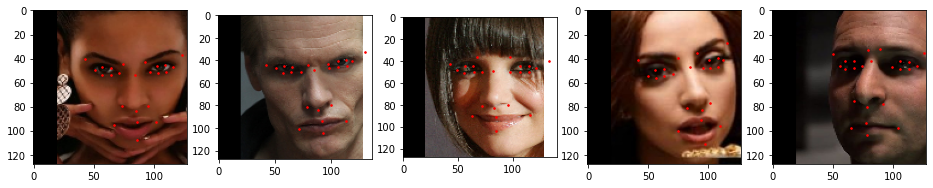

In [251]:
# show first 5 images from dataset
show_images(ds_sr)

In [252]:
# shift images up by 20 pixels
ds_su = ds_br_aug.map(lambda img,pts: shift_image(img,pts,shift=(0,-20)))

  0%|▏                                                                                | 5/2580 [00:00<04:13, 10.15it/s]


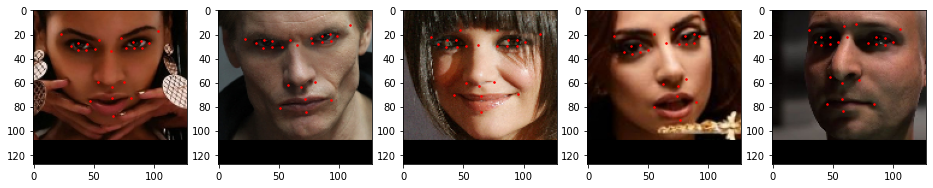

In [253]:
# show first 5 images from dataset
show_images(ds_su)

In [254]:
# shift images down by 20 pixels
ds_sd = ds_br_aug.map(lambda img,pts: shift_image(img,pts,shift=(0,20)))

  0%|▏                                                                                | 5/2580 [00:00<04:14, 10.12it/s]


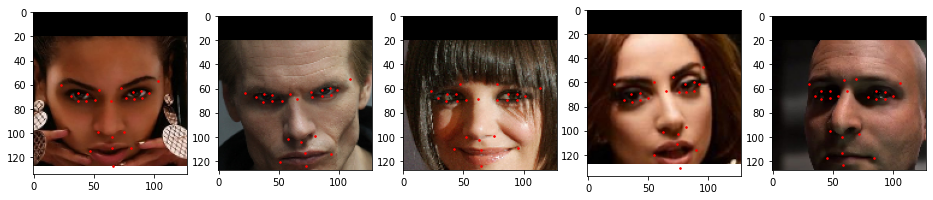

In [255]:
# show first 5 images from dataset
show_images(ds_sd)

In [256]:
# create augmentation pipeline  
ds_hs = ds_sl.concatenate(ds_sr)
ds_vs = ds_su.concatenate(ds_sd)
ds_shift = ds_hs.concatenate(ds_vs)
ds_shift_aug = ds_ro_aug.concatenate(ds_shift)

In [258]:
# save dataset to hard drive
with h5py.File('../input/AugmentedImageDataset.h5', 'a') as hfa:
    first = True  # flag to create dataset
    img_shape = None, INPUT_SHAPE[0], INPUT_SHAPE[1], 3  # 3 color channels
    pts_shape = None, REQ_PTS_SIZE, 2 # 2 co-ordinates(x,y)
    for img,pts in ds_shift_aug:
        image = tf.expand_dims(img, axis=0)
        points = tf.expand_dims(pts, axis=0)
        if first:
            hfa.create_dataset('images', data=image, compression="gzip", chunks=True, maxshape=img_shape)
            hfa.create_dataset('landmarks', data=points, compression="gzip", chunks=True, maxshape=pts_shape)
            first = False
        else:
            hfa['images'].resize((hfa['images'].shape[0] + 1), axis=0)
            hfa['images'][-1:] = image
            hfa['landmarks'].resize((hfa['landmarks'].shape[0] + 1), axis=0)
            hfa['landmarks'][-1:] = points
    print(hfa['images'].shape, hfa['landmarks'].shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2580/2580 [03:34<00:00, 12.02it/s]


(108360, 128, 128, 3) (108360, 24, 2)


(108360, 128, 128, 3) (108360, 24, 2)


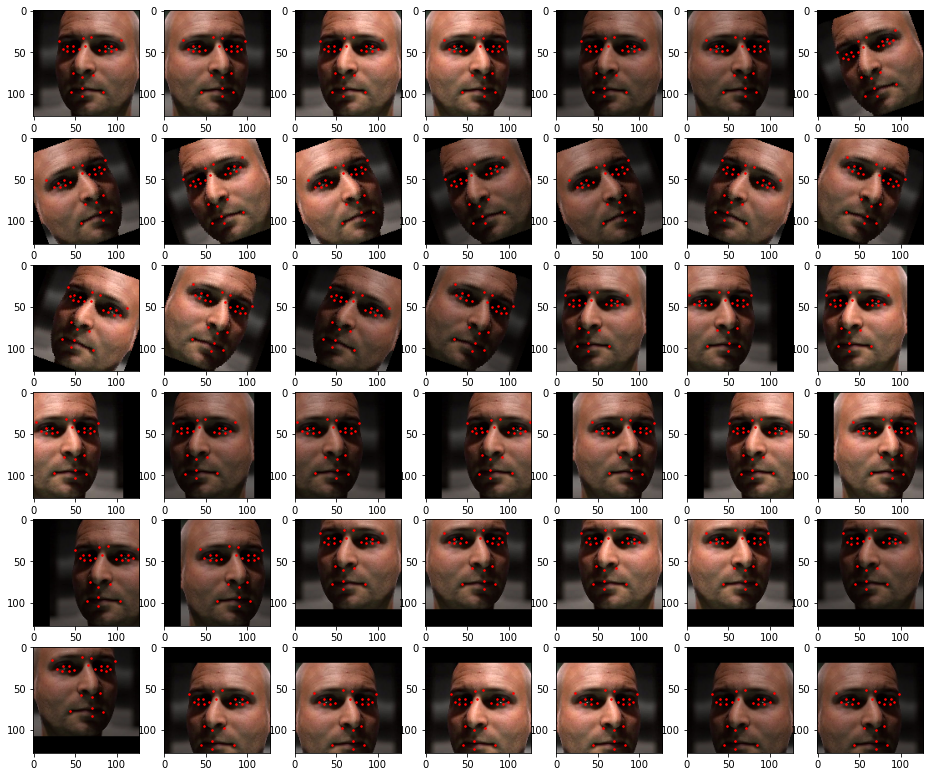

In [262]:
# check augmentations per image
with h5py.File('../input/AugmentedImageDataset.h5', 'r') as h:
    print(h['images'].shape,h['landmarks'].shape)
    fig = plt.figure(figsize=(16, 16)) 
    for i in range(42):  
        image = h['images'][i*2580+4]  
        points = h['landmarks'][i*2580+4]
        fig.add_subplot(7, 7, i+1)   
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.scatter(points[:,0], points[:,1], marker='.', s=10, color='red')

In [5]:
# read data from saved file
df_pre = tf.data.Dataset.from_generator(
    generator('../input/AugmentedImageDataset.h5'), 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=([128,128,3], [24,2]))

In [7]:
# prepare and save dataset to hard drive to train the model
with h5py.File('../input/Dataset.h5', 'a') as hfd:
    first = True  # flag to create dataset
    img_shape = None, INPUT_SHAPE[0], INPUT_SHAPE[1], 1
    pts_shape = None, REQ_PTS_SIZE*2  
    for img,pts in df_pre:
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        img = img/255
        image = tf.expand_dims(img, axis=0)
        image = tf.expand_dims(image, axis=-1)
        pts = tf.reshape(pts, [REQ_PTS_SIZE*2])
        points = tf.expand_dims(pts, axis=0)
        if first:
            hfd.create_dataset('images', data=image, compression="gzip", chunks=True, maxshape=img_shape)
            hfd.create_dataset('landmarks', data=points, compression="gzip", chunks=True, maxshape=pts_shape)
            first = False
        else:
            hfd['images'].resize((hfd['images'].shape[0] + 1), axis=0)
            hfd['images'][-1:] = image
            hfd['landmarks'].resize((hfd['landmarks'].shape[0] + 1), axis=0)
            hfd['landmarks'][-1:] = points
    print(hfd['images'].shape, hfd['landmarks'].shape)

100%|█████████████████████████████████████████████████████████████████████████| 108360/108360 [11:15<00:00, 160.33it/s]


(108360, 128, 128, 1) (108360, 48)


In [8]:
# load data from saved file
df_train = tf.data.Dataset.from_generator(
    generator('../input/Dataset.h5'), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([INPUT_SHAPE[0],INPUT_SHAPE[1],1], [REQ_PTS_SIZE*2]))

  0%|                                                                                       | 0/108360 [00:00<?, ?it/s]


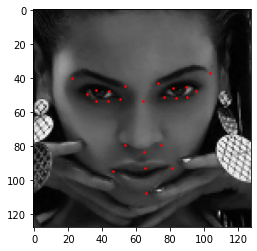

In [9]:
for img,ptr in df_train.take(1):
    plt.imshow(img, cmap='gray')
    plt.scatter(ptr[0::2], ptr[1::2], marker='.', s=10, color='red')

## Model Building

In [10]:
# function to build model to encode facial features
def encoder():
    # create a sequential model
    model = Sequential()
    in_shape = INPUT_SHAPE[0], INPUT_SHAPE[1], 1

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=in_shape))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_FEATURES*2))
   
    return model

In [11]:
# get model
model = encoder()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0

In [43]:
# Load a pre-trained model (if present)
if os.path.exists('../input/best_model.hdf5'):
    model = load_model('../input/best_model.hdf5')

# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = '../input/best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

In [44]:
# Train the model
history = model.fit(X_train,Y_train, epochs=100, batch_size=128, validation_split=0.05, callbacks=[checkpointer, reduce_lr])

Epoch 1/100
249/249 [==============================] - 61s 183ms/step - loss: 13.9049 - mae: 2.6863 - acc: 0.8006 - val_loss: 6.6538 - val_mae: 1.7514 - val_acc: 0.7929

Epoch 00001: val_mae improved from inf to 1.75145, saving model to ../input\best_model.hdf5
Epoch 2/100
249/249 [==============================] - 44s 177ms/step - loss: 10.8999 - mae: 2.4794 - acc: 0.8100 - val_loss: 5.8878 - val_mae: 1.8257 - val_acc: 0.8000

Epoch 00002: val_mae did not improve from 1.75145
Epoch 3/100
249/249 [==============================] - 44s 177ms/step - loss: 13.3319 - mae: 2.5999 - acc: 0.8037 - val_loss: 13.9406 - val_mae: 2.4549 - val_acc: 0.7310

Epoch 00003: val_mae did not improve from 1.75145
Epoch 4/100
249/249 [==============================] - 36s 144ms/step - loss: 13.3322 - mae: 2.6352 - acc: 0.7944 - val_loss: 16.3224 - val_mae: 2.2755 - val_acc: 0.7476

Epoch 00004: val_mae did not improve from 1.75145
Epoch 5/100
249/249 [==============================] - 33s 134ms/step - loss

Epoch 35/100
249/249 [==============================] - 34s 135ms/step - loss: 7.6038 - mae: 2.0631 - acc: 0.8448 - val_loss: 2.9293 - val_mae: 1.1062 - val_acc: 0.8500

Epoch 00035: val_mae did not improve from 1.01418
Epoch 36/100
249/249 [==============================] - 34s 135ms/step - loss: 7.4266 - mae: 2.0446 - acc: 0.8449 - val_loss: 2.7238 - val_mae: 1.0297 - val_acc: 0.8548

Epoch 00036: val_mae did not improve from 1.01418
Epoch 37/100
249/249 [==============================] - 34s 135ms/step - loss: 7.4472 - mae: 2.0483 - acc: 0.8456 - val_loss: 2.7686 - val_mae: 1.0473 - val_acc: 0.8524

Epoch 00037: val_mae did not improve from 1.01418
Epoch 38/100
249/249 [==============================] - 34s 135ms/step - loss: 7.4904 - mae: 2.0508 - acc: 0.8448 - val_loss: 2.7584 - val_mae: 1.0412 - val_acc: 0.8619

Epoch 00038: val_mae did not improve from 1.01418
Epoch 39/100
249/249 [==============================] - 34s 135ms/step - loss: 7.3915 - mae: 2.0489 - acc: 0.8443 - val_


Epoch 00070: val_mae did not improve from 0.98793
Epoch 71/100
249/249 [==============================] - 34s 135ms/step - loss: 7.2763 - mae: 2.0212 - acc: 0.8473 - val_loss: 2.6315 - val_mae: 1.0022 - val_acc: 0.8524

Epoch 00071: val_mae did not improve from 0.98793
Epoch 72/100
249/249 [==============================] - 34s 135ms/step - loss: 7.3312 - mae: 2.0322 - acc: 0.8458 - val_loss: 2.6367 - val_mae: 1.0048 - val_acc: 0.8595

Epoch 00072: val_mae did not improve from 0.98793
Epoch 73/100
249/249 [==============================] - 34s 135ms/step - loss: 7.3774 - mae: 2.0320 - acc: 0.8420 - val_loss: 2.6893 - val_mae: 1.0244 - val_acc: 0.8667

Epoch 00073: val_mae did not improve from 0.98793
Epoch 74/100
249/249 [==============================] - 34s 135ms/step - loss: 7.3305 - mae: 2.0296 - acc: 0.8463 - val_loss: 2.6167 - val_mae: 0.9981 - val_acc: 0.8595

Epoch 00074: val_mae did not improve from 0.98793
Epoch 75/100
249/249 [==============================] - 34s 135ms/ste

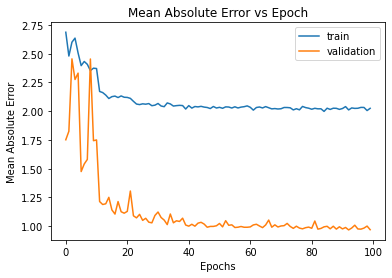

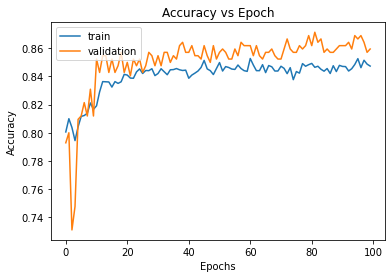

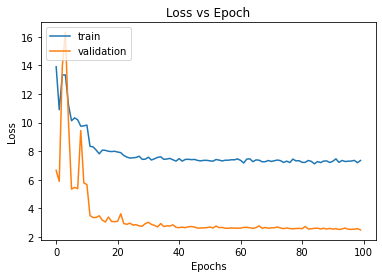

In [45]:
# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

In [50]:
Y_pred = model.predict(X_train[:25])

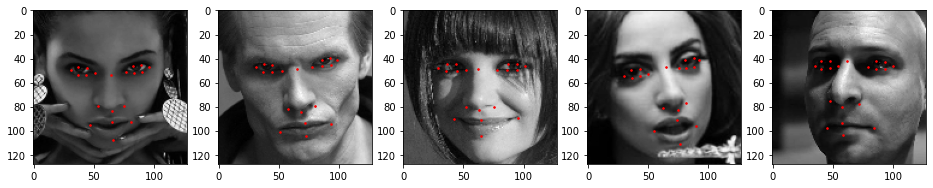

In [49]:
# check loaded images
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.scatter(Y_train[i][0::2], Y_train[i][1::2], marker='.', s=10, color='red')

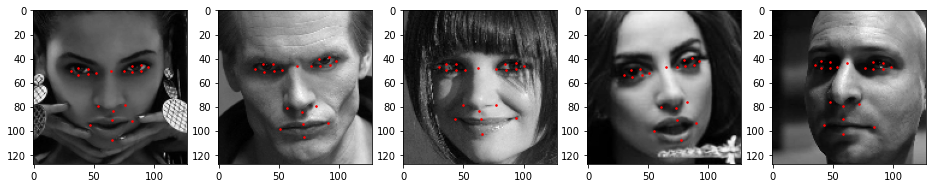

In [51]:
# check loaded images
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.scatter(Y_pred[i][0::2], Y_pred[i][1::2], marker='.', s=10, color='red')

In [65]:
test_image_or = cv2.imread('../images/pradip solanki.jpg')
#test_image_or = cv2.imread(train_data_path + 'indoor_002.png')

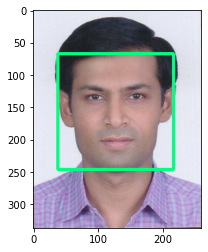

In [66]:
faces = faceCascade.detectMultiScale(test_image_or)
# create bounding box
for x, y, w, h in faces:
    cv2.rectangle(test_image_or,(x,y),(x+w, y+h),(127, 255,0),3)
# show the test image
plt.imshow(cv2.cvtColor(test_image_or, cv2.COLOR_BGR2RGB))

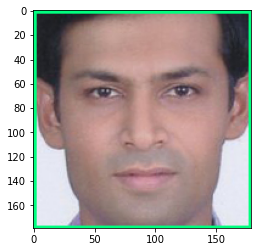

In [67]:
test_image_or = test_image_or[faces[0][1]:faces[0][1]+faces[0][3],faces[0][0]:faces[0][0]+faces[0][2]]
plt.imshow(cv2.cvtColor(test_image_or, cv2.COLOR_BGR2RGB))

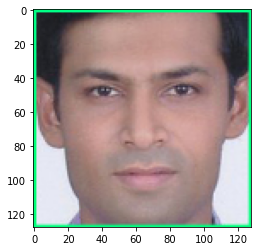

In [68]:
test_image = cv2.resize(test_image_or, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

(1, 128, 128, 1)


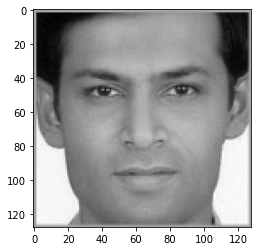

In [69]:
test = prepare_data(test_image[np.newaxis,...])
print(test.shape)
plt.imshow(test[0], cmap='gray')

In [70]:
test_lb = model.predict(test)

In [71]:
test_lb.shape

(1, 40)

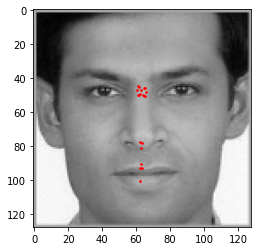

In [72]:
plt.imshow(test[0], cmap='gray')
plt.scatter(test_lb[0][0::2], test_lb[0][1::2], marker='.', s=10, color='red')

In [7]:
# Live test demo
camera = cv2.VideoCapture(0)
# read first frame
webcam, frame = camera.read()
# loop till camera is open
while webcam:
    # convert image to grey scale to reduce computation 
    image_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect faces from the image
    faces = faceCascade.detectMultiScale(frame)
    # create bounding box if a face is detected
    if len(faces) > 0:
        for x, y, w, h in faces:
            # detected faces shown in color image
            cv2.rectangle(frame,(x,y),(x+w, y+h),(127, 255,0),3)
        
    cv2.imshow('LIVE CLASS MONITORING SYSTEM', frame)
    # read next frame
    webcam, frame = camera.read()
    # press 'q' to exit the window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
camera.release()
cv2.destroyAllWindows()

### VGG-16

In [23]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

I am using [Face Recognition Library](https://github.com/ageitgey/face_recognition) to detect face. This library is built on [dlib](http://dlib.net/)'s pretrain model.

We can run deep learning algorithm to recognize face from live video and mark attendance based on face recognition.
First we need dataset of images for all student in class to do face recodntition attendance. To create data set we need to add one image (in '.jpg' format) of each student in class with image name as 'FirstName LastName'. This name will be used to mark attendance in register. 

In [4]:
# check the dataset
image_path = '../images/'
student_list = os.listdir(image_path)
print(student_list)

['andrew ng.jpg', 'pradip solanki.jpg']


We have student data now wee need to create attendance register to mark attendace of each student.

In [5]:
# create dataframe to keep track of attendace
attendance_register = pd.DataFrame()
# add name of each student from image name
attendance_register['image_name'] = student_list
# get name of students by removing last 4 character from image name ('.jpg')
attendance_register['Name'] = attendance_register['image_name'].apply(lambda x: x[:-4])
# initially mark every student as absent
attendance_register['Attendance'] = 'A'
# record session time for each student
attendance_register['Session Time'] = '0:00:00'
# remove unwanted column
attendance_register.drop(columns=['image_name'],inplace=True)
# check the register
attendance_register

Name Attendance Session Time
0       andrew ng          A      0:00:00
1  pradip solanki          A      0:00:00

We have dataset now we can encode each student image with 128-dimension face encoding. This encoding will be used to compare encoding from live video feed to mark attendance.

In [6]:
class_enc = []
# create a list of face encoding from each student image
for student in student_list:
    # load an image file into a numpy array
    image = fr.load_image_file(image_path + student)
    # given an image, face_encodings method returns the 128-dimension face encoding for each face in the image.
    encoding = fr.face_encodings(image)[0]  # extract first encoding from the list
    # add each encoding into the list
    class_enc.append(encoding)

Now we can build real time face recognition attendace system. We need to capture frames from webcam and treat each frame as individual image to run face recognition on it. We can encode each frame with face encoding and if encoding can be done then we can compare this encoding with our class encoding and find the minimum distance between images to determine match. Once we have match from live video we can mark attendance to the matching image of the student.

In [7]:
def match_encoding(ref_enc, test_image, tolerance):
    '''
    Given an image performs face encoding and compare it with given list of encodings.
    If distance between images is less than tolerance then index of encoding from the list that matched
    with the test image is returned.
    '''
    index = -1
    try:
        # encode the test image
        enc_test = fr.face_encodings(test_image)[0]  # extract first encoding from the list
        # compare a list of face encodings against a test encoding to see if they match
        # euclidean distance for each face encoding is calculated and compared with tolerance value
        # tolerance is the distance between faces to consider it a match
        result = fr.face_distance(ref_enc,enc_test)
        # get the index of minimum distance
        min_dist_index = np.argmin(result)
        # compare with tolerance value
        if result[min_dist_index] <= tolerance:
            index = min_dist_index
    except:
        # face encoding failed, there is no face present in image or can not match face encoding within tolerance limit
        pass
    return index

In [8]:
def mark_attendance(register, index, session_start_time):
    # mark attendance in register to given index
    register.iloc[[index],[1]] = 'P'
    # add session time
    prev_session_time_str = register.iloc[index][2]
    # convert previous session time to int(in seconds) from string(h:mm:ss)
    h, m, s = prev_session_time_str.split(':')
    prev_time = int(h)*3600 + int(m)*60 + int(s)
    # calculate new session time
    new_time = prev_time + time.time() - session_start_time
    # convert new session time to string(h:mm:ss)
    time_str = time.strftime('%H:%M:%S', time.gmtime(new_time))
    register.iloc[[index],[2]] = time_str 

## Drowsiness detector

Drowsiness is described as unusual sleepiness. Drowsiness is a factor for student that are falling behind in there study. We can use deep learning algorithum to detect drowsiness and sound alarm to aleart the drowsy student. This will help them pay more attention in class.

To detect drowsiness we apply facial landmark detection and extract the eye regions. Once we have the eye regions, we can compute the eye aspect ratio to determine if the eyes are closed. If eyes have been closed for a sufficiently long time, we will sound an alarm to wake up the student.

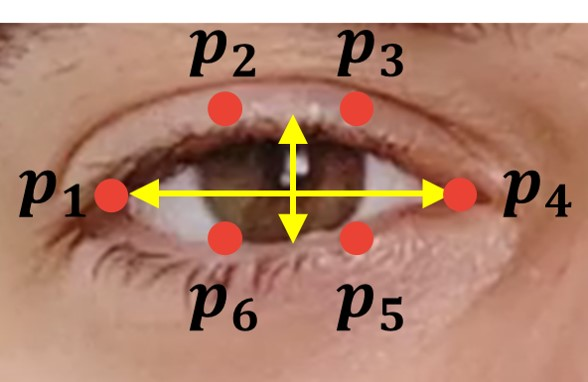

In [9]:
def ratio(points):
    # from list of tuples calculate aspect ratio
    # initialize default values for extreme points
    left = 1000000
    right = 0
    up = 1000000
    down = 0
    # iterate over all points to find extreme points
    for p in points:
        if p[0] < left:
            left = p[0]
        if p[0] > right:
            right = p[0]
        if p[1] < up:
            up = p[1]
        if p[1] > down:
            down = p[1]
    # calculate aspect ratio
    ratio = (down - up) / (right - left)
    return ratio

In [10]:
def calculate_ear(image):
    '''
    From given image, detect facial features and extracts eyes.
    If eye feature is extracted calculate eye aspect ratio and return the average of ratio from both eyes.
    Argument:
        image: input image 
    returns:
        ear: float indicating average eye aspect ratio
    '''
    ear = 0.5 # default start ratio
    try:
        # get facial landmarks as dictionary
        landmarks = fr.face_landmarks(image)
        # extract left and right eye points from landmarks
        left_eye_points = landmarks[0]['left_eye']
        right_eye_points = landmarks[0]['right_eye']
        ear_left = ratio(left_eye_points)
        ear_right = ratio(right_eye_points)
        ear = (ear_left + ear_right)/2
    except:
        # unable to load facial features
        pass
    return ear

In [11]:
def drowsiness_alert(image):
    '''Adds text in image for drowsiness alert'''
    return cv2.putText(image,text='Drowsiness Alert!',org=(10,30),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=1,color=(0,0,255),thickness=2)

In [12]:
def not_attentive(image):
    '''Adds text in image for attention alert'''
    return cv2.putText(image,text='Not attentive!',org=(10,20),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=0.5,color=(0,0,0),thickness=1)

In [13]:
def attendance_notification(image,name):
    '''Adds text in image to indicate attendance is marked'''
    msg = 'Welcome ' + name + ' your attendance is marked.'
    return cv2.putText(image,text=msg,org=(10,20),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=0.5,color=(0,255,0),thickness=1)

To detect drowsiness we can mark time when eyelids are closed and mark time when eyelids are open then take difference of time (total time when eyes are in closed state). If this time is very small(in milisecond scale) we can say that is was due to normal blink. We can set a sufficiently long time as threshold to detect drowsiness 

In [14]:
def run_live_monitoring(register, ref_enc, tolerance=0.6, ear_threshold=0.2, time_delta=2):
    '''
    From given register and reference encoding mark attendance in register with face recognition
    and provide drowsiness aleart from given threshold values
    '''
    # use thread for plying sound in background while main thread can execute program 
    t_sound = threading.Thread(target= beepy.beep,args=(6,)) # play alarm sound when running
    # declare varaibles to detect time difference
    session_start_time = None
    gaze_away_start_time = None
    eye_closed_start_time = None
    attendance_notification_start_time = None
    prev_index = None
    
    # capture frames from webcam
    camera = cv2.VideoCapture(0)
    # read first frame
    webcam, frame = camera.read()
    # loop till camera is open
    while webcam:
        output = frame
        # get index of matching student encoding
        index = match_encoding(ref_enc, frame, tolerance)
        # if index is not -1 means matching student ecoding found
        if index != -1:
            prev_index = index  # update previous index value
            # there are 2 possibilities either student is already attending class
            # or just joined the class
            # if session start time is 'None', means student just joined the class
            # we can mark student's attendance
            if session_start_time == None:
                # start new session for student
                session_start_time = time.time()
                # if student have not marked as present then show notification
                if register.iloc[index]['Attendance'] == 'A':
                    # start attendance notification time
                    attendance_notification_start_time = time.time()
                    # output notification
                    name = register.iloc[index]['Name']
                    output = attendance_notification(frame, name)
                    # mark student's attendance
                    mark_attendance(register, index, session_start_time)
            else:
                # if student is already attending class, check for notification time out
                # we will show notification for 3 seconds
                if attendance_notification_start_time != None:
                    if (time.time() - attendance_notification_start_time) < 3:
                        # continue showing notification for 3 second
                        name = register.iloc[index]['Name']
                        output = attendance_notification(frame, name)
                    else:
                        # close notification
                        attendance_notification_start_time = None
                # check for drowsiness
                ear = calculate_ear(frame)
                if ear < ear_threshold:
                    # if eyes are closed there are 2 posibilities 
                    # 1. it's blink
                    # 2. drowsiness
                    # first check for blink
                    if eye_closed_start_time == None:
                        # start timer for closed eye
                        eye_closed_start_time = time.time()
                    else:
                        # if eyes already closed, check for duration 
                        # when duration is more than time_delta we consider it as drowsiness
                        if (time.time() - eye_closed_start_time) > time_delta:
                            # put notification alert
                            output = drowsiness_alert(frame)
                            # play alarm sound
                            if not t_sound.is_alive():
                                t_sound = threading.Thread(target= beepy.beep,args=(6,))
                                t_sound.start()
                else:
                    # when eyes are open stop the timers
                    eye_closed_start_time = None
        # when matching index is not found we can assume either student not attending class
        # or algorithm unable to detect face of student
        # to remove second possiblity we calculate gaze away time
        else:
            # if session is not started then no one in front of webcam is attending the class 
            if session_start_time != None:
                if gaze_away_start_time == None:
                    gaze_away_start_time = time.time()
                else:
                    # calculate the gaze away time to detect if student not attentive
                    if (time.time() - gaze_away_start_time) > time_delta:
                        # end current session time for student and show notification
                        mark_attendance(register, prev_index, session_start_time)
                        gaze_away_start_time = None # reset gazez away time
                        session_start_time = None # reset session time
                        output = not_attentive(frame)
            else:
                # if student was attending class continue showing notification
                if prev_index != None:
                    if register.iloc[prev_index]['Attendance'] == 'P':
                        output = not_attentive(frame)
        # show output image on a window
        cv2.imshow('LIVE CLASS MONITORING SYSTEM', output)
        # read next frame
        webcam, frame = camera.read()
        # press 'q' to exit the window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            if (prev_index != None) and (session_start_time != None):
                mark_attendance(register, prev_index, session_start_time)
            break
    camera.release()
    cv2.destroyAllWindows()

In [15]:
# run live monitoring sysetem
run_live_monitoring(attendance_register, class_enc, tolerance=0.6, ear_threshold=0.2, time_delta=2)

In [16]:
# check attendance
attendance_register

Name Attendance Session Time
0       andrew ng          A      0:00:00
1  pradip solanki          P     00:00:24